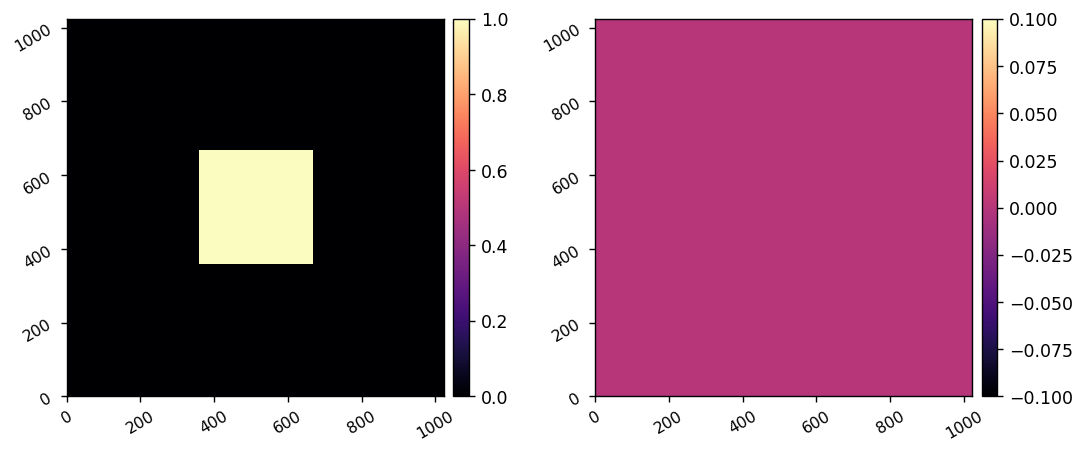

In [34]:
import numpy as np
import cupy as cp
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

from roman_cgi_iefc_2.poppy_roman_cgi_phasec import cgi
from roman_cgi_iefc_2 import iefc_utils as iefcu
from roman_cgi_iefc_2 import iefc_sim_3probes as iefc

import misc

data_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
flatmaps_dir = Path.home()/'src/pyfalco/roman/flatmaps'

dm1_flatmap = fits.getdata(flatmaps_dir/'dm1_m_flat_hlc_band1.fits')
dm2_flatmap = fits.getdata(flatmaps_dir/'dm2_m_flat_hlc_band1.fits')
dm1_design = fits.getdata(flatmaps_dir/'dm1_m_design_hlc_band1.fits')
dm2_design = fits.getdata(flatmaps_dir/'dm2_m_design_hlc_band1.fits')

hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)
misc.myimshow2(hlci.inwave.intensity.get(), hlci.inwave.phase.get())

npsf = hlci.npsf
Nact = hlci.Nact

Propagating wavelength 575.000 nm.
PSF calculated in 0.425s


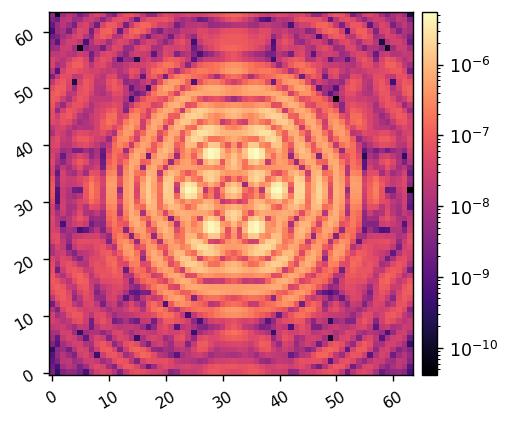

In [4]:
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)
ref_psf = hlci.calc_psf()[-1]
misc.myimshow(ref_psf.intensity, lognorm=True)

(calc_psf pid=87969) Propagating wavelength 575.000 nm.
All PSFs calculated in 0.457s
(calc_psf pid=87969) PSF calculated in 0.417s


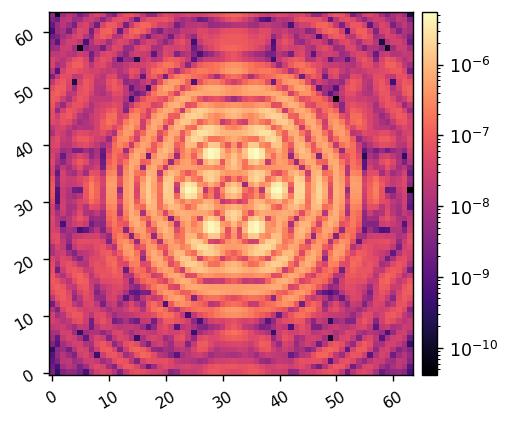

In [8]:
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)
ref_psf = hlci.calc_psfs()[0][-1]
misc.myimshow(ref_psf.intensity, lognorm=True)

# Create dark hole ROI to calibrate and control

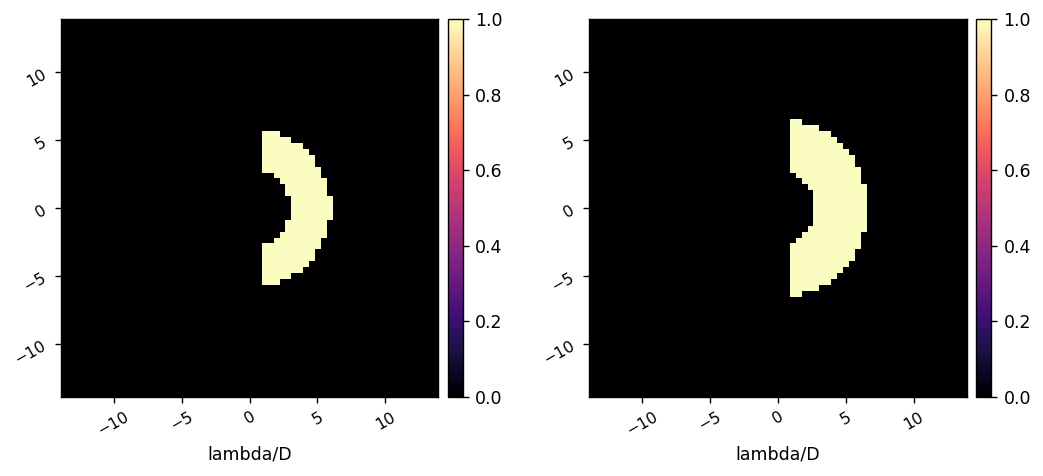

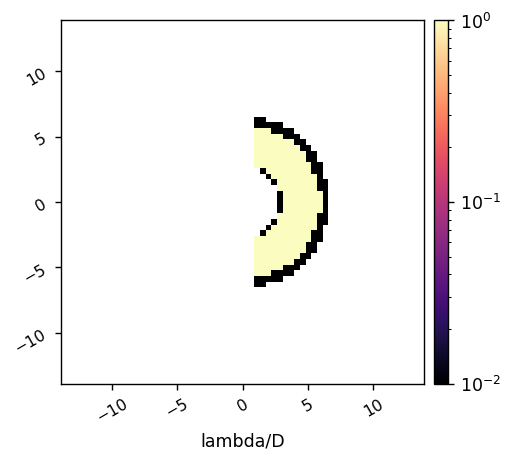

In [9]:
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)
xfp = np.linspace(-0.5, 0.5, npsf) * npsf * hlci.psf_pixelscale_lamD
xf,yf = np.meshgrid(xfp,xfp)

edge = 1
iwa = 3
owa = 6

# Create the mask that is used to select which region to make dark.
dh_params = {
    'inner_radius' : iwa,
    'outer_radius' : owa,
    'edge_position' : edge,
    'direction' : '+x'
}
dh_mask = iefcu.create_annular_focal_plane_mask(xf, yf, dh_params).ravel()

#Create the mask that is used to select which region to make dark.
control_params = {
    'inner_radius' : iwa-0.2,
    'outer_radius' : owa+0.7,
    'edge_position' : edge,
    'direction' : '+x'
}
control_mask = iefcu.create_annular_focal_plane_mask(xf, yf, control_params).ravel()

relative_weight = 0.99
weights = dh_mask * relative_weight + (1 - relative_weight) * control_mask

misc.myimshow2(dh_mask.reshape(npsf,npsf), control_mask.reshape(npsf,npsf), 
               pxscl1=hlci.psf_pixelscale_lamD, pxscl2=hlci.psf_pixelscale_lamD)
misc.myimshow(weights.reshape(npsf,npsf), lognorm=True, pxscl=hlci.psf_pixelscale_lamD)


# Create probe and fourier modes

Creating Fourier modes:  (64, 64)
Calibration modes required: 128


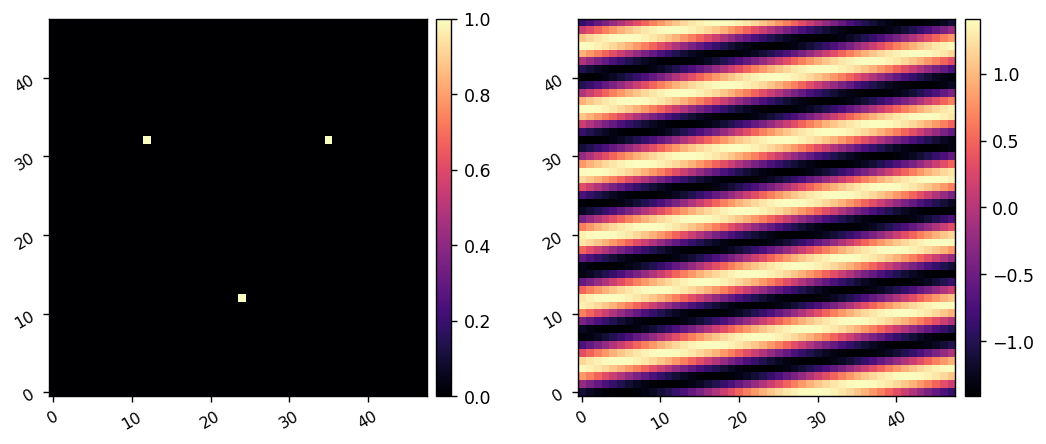

In [18]:
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=False, ngpus=1/4)

probe_modes_1 = iefcu.create_probe_poke_modes(Nact, 1*Nact//4, 2*Nact//3, 3*Nact//4-1, 2*Nact//3)
probe_modes_2 = iefcu.create_probe_poke_modes(Nact, 1*Nact//2, 1*Nact//4, 3*Nact//4-1, Nact//2)
probe_modes = np.vstack((probe_modes_1, probe_modes_2[0]))
calibration_modes, fx, fy = iefcu.create_fourier_modes(xfp, control_mask.reshape((npsf,npsf)), Nact, circular_mask=False)

calibration_amplitude = 0.006 * hlci.wavelength_c.to(u.m).value
probe_amplitude = 0.05 * hlci.wavelength_c.to(u.m).value
nmodes = calibration_modes.shape[0]

print('Calibration modes required: {:d}'.format(nmodes))
# misc.myimshow2((probe_modes[0] - probe_modes[1]).reshape((Nact,Nact)), calibration_modes[0].reshape(Nact,Nact))
misc.myimshow2((probe_modes[0] + probe_modes[1] + probe_modes[2]).reshape((Nact,Nact)), 
               calibration_modes[0].reshape(Nact,Nact))


In [56]:

hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=True, ngpus=1/6)
diff_images, images = iefc.take_measurement(hlci, probe_modes, probe_amplitude, DM=1, return_all=True, pca_modes=None)

diff_images.shape, images.shape

((3, 4096), (6, 4096))

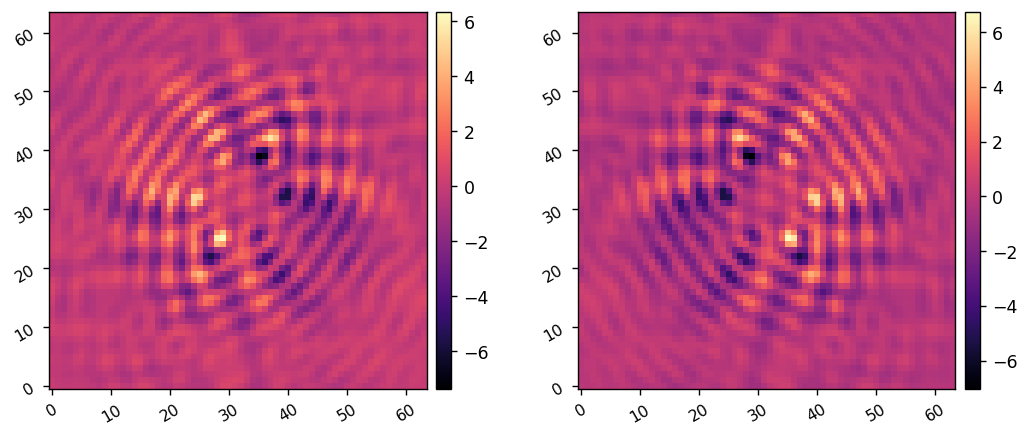

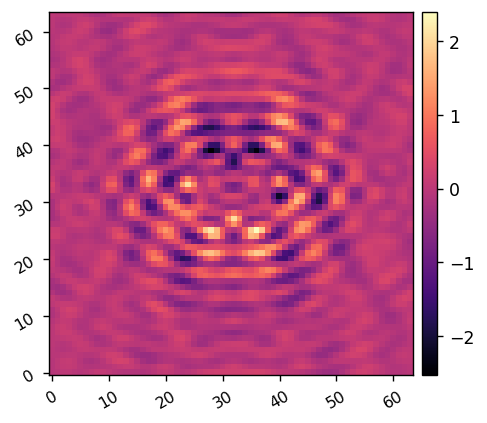

In [57]:
misc.myimshow2(diff_images[0].reshape(npsf,npsf), diff_images[1].reshape(npsf,npsf))
misc.myimshow(diff_images[2].reshape(npsf,npsf))

# Calibrate IEFC (or load in previous calibration data)

In [19]:
fname = 'dshaped_3probes_Nopds_polaxis{:d}_iwa{:.1f}_owa{:.1f}'.format(hlci.polaxis, 
                                                           dh_params['inner_radius'], dh_params['outer_radius'])
print(fname)

dshaped_3probes_Nopds_polaxis0_iwa3.0_owa6.0


In [20]:
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=True, ngpus=1/6)

response_cube, calibration_cube = iefc.calibrate(hlci, probe_amplitude, probe_modes, 
                                                 calibration_amplitude, calibration_modes, DM=1, start_mode=0)

Calibrating I-EFC...
	Calibrated mode 1 / 128 in 3.526s
	Calibrated mode 2 / 128 in 6.244s
	Calibrated mode 3 / 128 in 8.982s
	Calibrated mode 4 / 128 in 11.749s
	Calibrated mode 5 / 128 in 14.514s
	Calibrated mode 6 / 128 in 17.274s
	Calibrated mode 7 / 128 in 20.067s
	Calibrated mode 8 / 128 in 22.820s
	Calibrated mode 9 / 128 in 25.589s
	Calibrated mode 10 / 128 in 28.356s
	Calibrated mode 11 / 128 in 31.157s
	Calibrated mode 12 / 128 in 33.968s
	Calibrated mode 13 / 128 in 36.798s
	Calibrated mode 14 / 128 in 39.606s
	Calibrated mode 15 / 128 in 42.378s
	Calibrated mode 16 / 128 in 45.194s
	Calibrated mode 17 / 128 in 48.001s
	Calibrated mode 18 / 128 in 50.818s
	Calibrated mode 19 / 128 in 53.583s
	Calibrated mode 20 / 128 in 56.411s
	Calibrated mode 21 / 128 in 59.216s
	Calibrated mode 22 / 128 in 62.048s
	Calibrated mode 23 / 128 in 64.867s
	Calibrated mode 24 / 128 in 67.686s
	Calibrated mode 25 / 128 in 70.482s
	Calibrated mode 26 / 128 in 73.293s
	Calibrated mode 27 / 128 in 

In [22]:
iefcu.save_pickle(data_dir/'response-data'/fname, response_cube)
iefcu.save_pickle(data_dir/'calibration-data'/fname, calibration_cube)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/response-data/dshaped_3probes_Nopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/calibration-data/dshaped_3probes_Nopds_polaxis0_iwa3.0_owa6.0


In [23]:
response_cube = iefcu.load_pickle(data_dir/'response-data'/fname)
calibration_cube = iefcu.load_pickle(data_dir/'calibration-data'/fname)

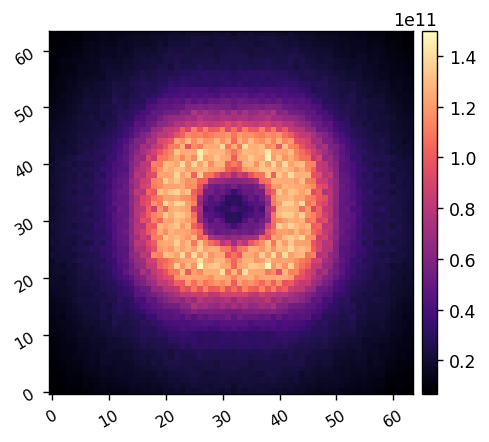

In [28]:
response_sum = np.sum(abs(response_cube), axis=(0,1))
misc.myimshow(response_sum.reshape(64,64).get())

# Create control matrix

In [31]:
reload(iefc)
# OPTIONAL: Filter the calibration files by subtracting PCA modes
# npca = 3
# filtered_response_cube, pca_modes = iefc.remove_k_pca_modes(response_cube, k=npca)

control_matrix_1 = iefc.construct_control_matrix(response_cube, cp.array(weights.flatten()), WLS=True, rcond=1e-2)
control_matrix_2 = iefc.construct_control_matrix(response_cube, cp.array(weights.flatten()), WLS=False, rcond=1e-2)

Using Weighted Least Squares 
Using Tikhonov Inverse


# Run IEFC

In [32]:
reload(iefc)
hlci = cgi.CGI_POPPY(polaxis=0, use_opds=False, use_fieldstop=False, quiet=True, ngpus=1/4)

images, dm_commands = iefc.run(hlci, control_matrix, probe_modes, probe_amplitude, 
                               calibration_modes, cp.array(weights), 
                               num_iterations=10, gain=-0.5, leakage=0.0,
                               display=False)

Running I-EFC...
	Closed-loop iteration 1 / 10
	Closed-loop iteration 2 / 10
	Closed-loop iteration 3 / 10
	Closed-loop iteration 4 / 10
	Closed-loop iteration 5 / 10
	Closed-loop iteration 6 / 10
	Closed-loop iteration 7 / 10
	Closed-loop iteration 8 / 10
	Closed-loop iteration 9 / 10
	Closed-loop iteration 10 / 10
I-EFC loop completed in 19.620s.


In [163]:
iefcu.save_pickle(data_dir/'image-results'/fname, images)
iefcu.save_pickle(data_dir/'dm-results'/fname, dm_commands)

Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/image-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0
Saved wavefronts to:  /groups/douglase/kians-data-files/roman-cgi-iefc-data/dm-results/dshaped_Yopds_polaxis0_iwa3.0_owa6.0


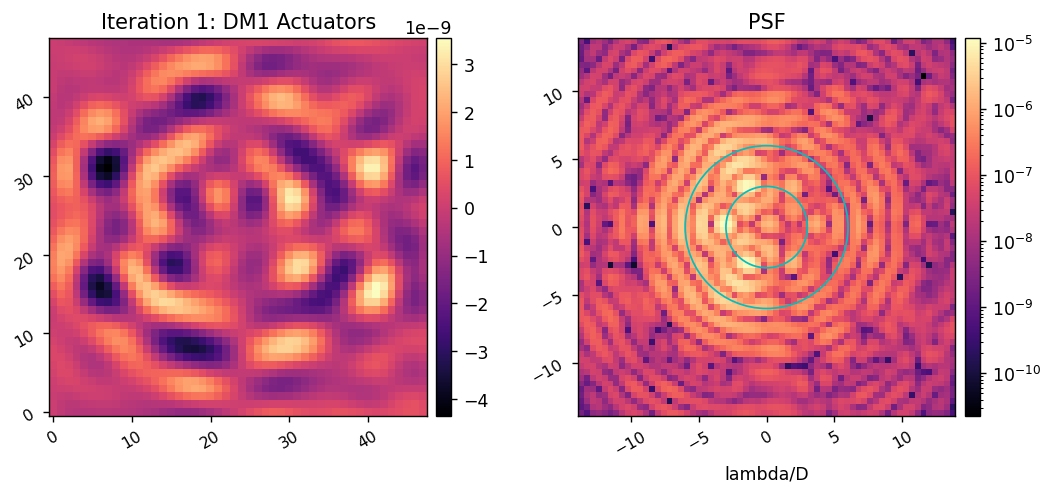

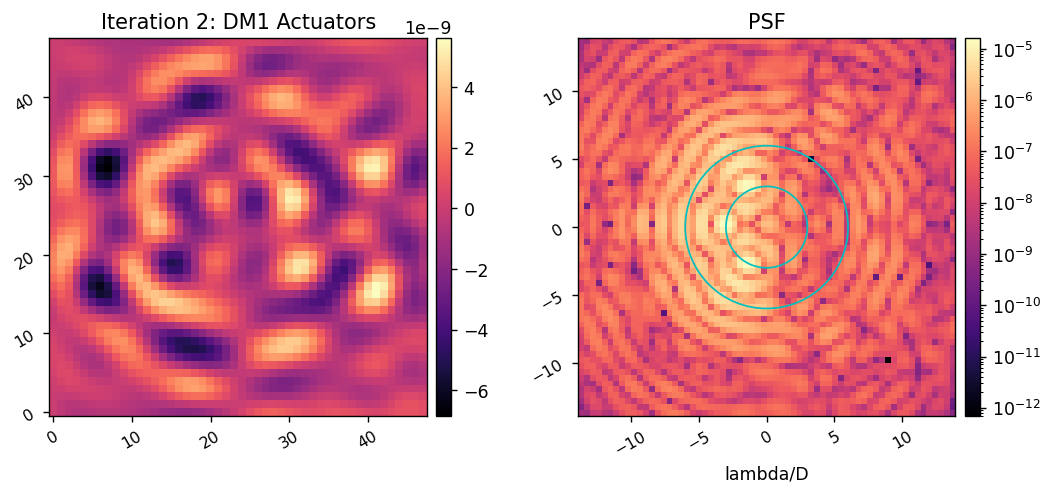

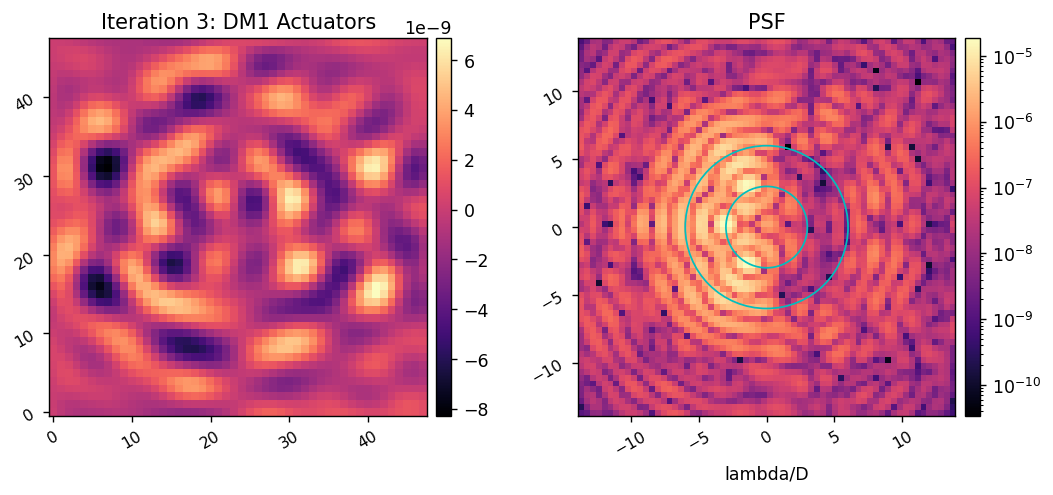

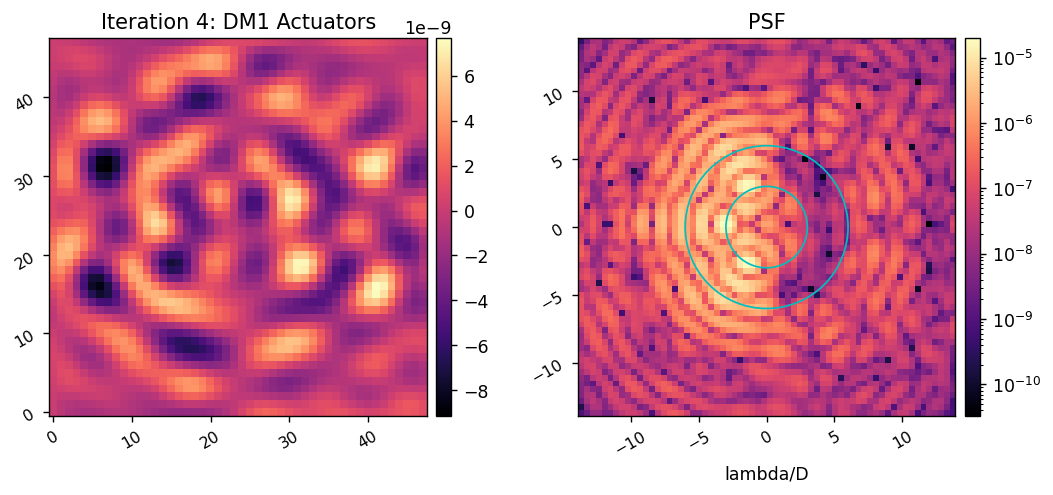

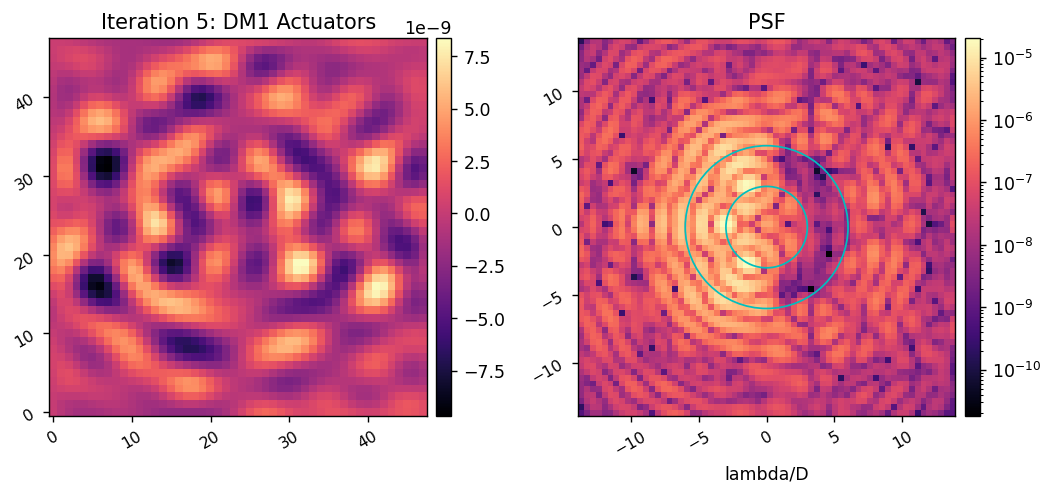

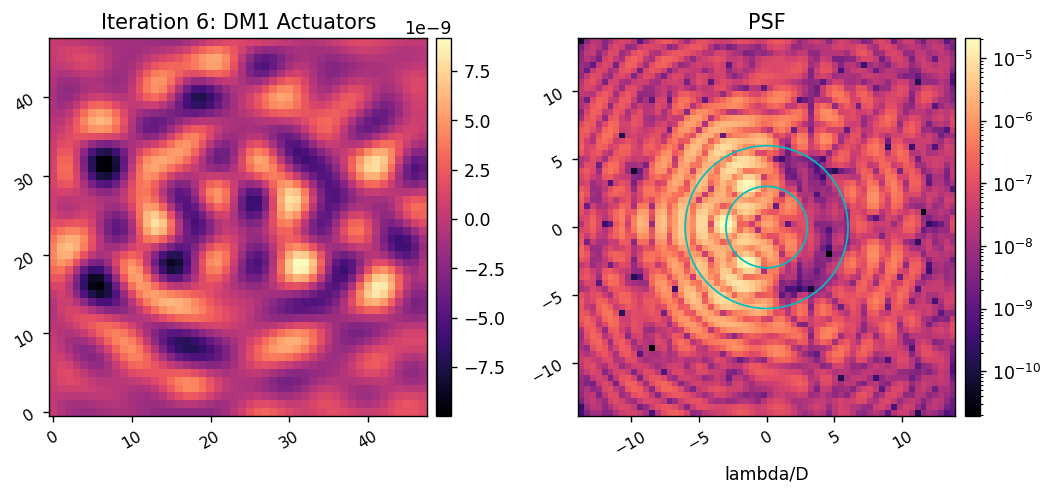

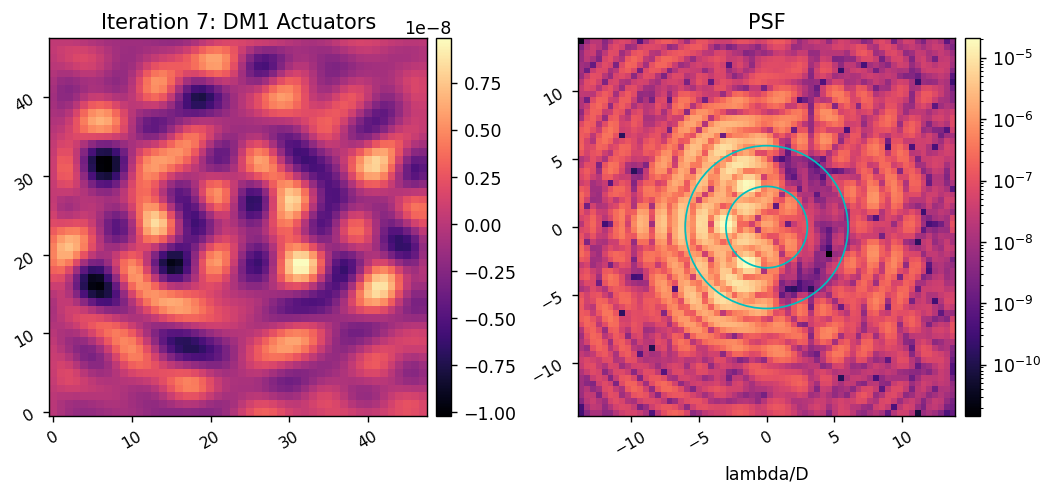

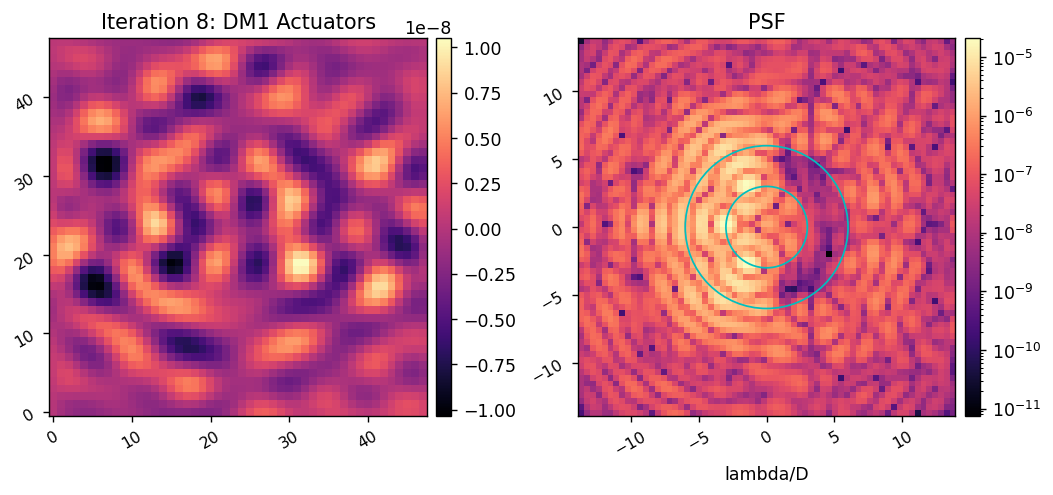

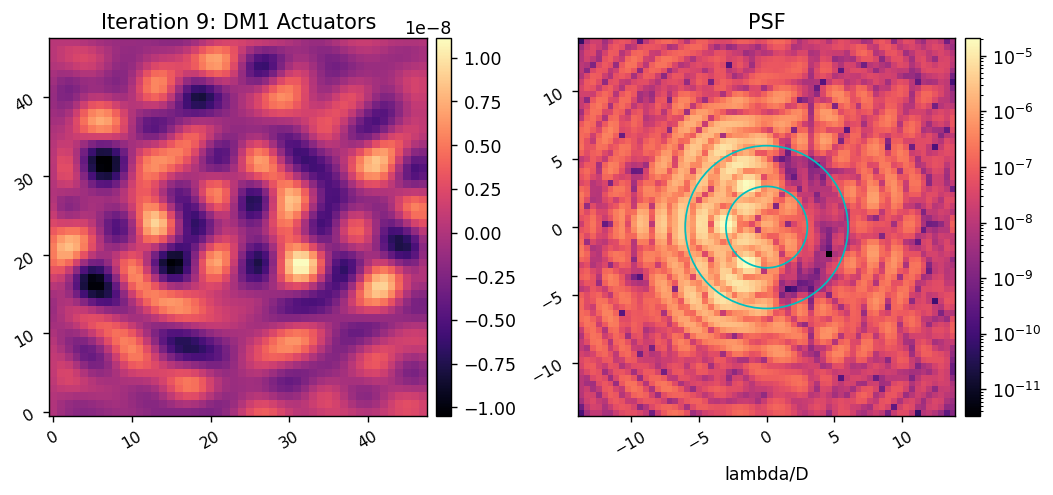

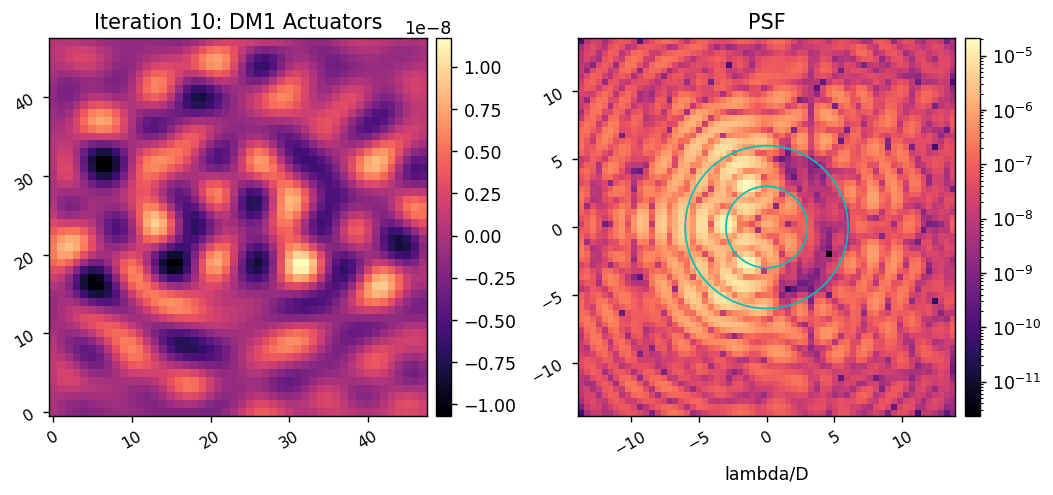

In [33]:
for i in range(len(images)):
    patches = iefcu.create_circ_patches(dh_params)
    misc.myimshow2(dm_commands[i], images[i].intensity.get(), 
                   'Iteration {:d}: DM1 Actuators'.format(i+1), 'PSF',
                   lognorm2=True, pxscl2=hlci.psf_pixelscale_lamD, patches2=patches)